In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils.metrics import iqm
from utils.metrics import UnbiasedExponentialMovingAverage as uema

In [2]:
data_path = os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/old/reprocessed.csv'
df = pd.read_csv(data_path)

In [3]:
def to_numpy(string_list):
    """Converts a string representation of a list of numbers to a NumPy array."""
    if not isinstance(string_list, str):
        return string_list
    try:
        # Remove the brackets and split by space
        numbers_str = string_list.strip('[]').split()
        # Convert the strings to floats and create a NumPy array
        return np.array([float(num) for num in numbers_str])
    except AttributeError:
        return np.nan  # Or handle non-string elements as needed

In [4]:
for metric in ['area', 'clean_area']:
    df[metric] = df[metric].apply(to_numpy)
areas = df['clean_area'].to_numpy()
areas = np.reshape(areas, (-1,56))  # needed for standard*.csv

In [5]:
area = np.array([iqm(areas[i,:], 0.0) for i in range(areas.shape[0])])
print(len(area))

2016


In [6]:
# remove night time
area = (np.reshape(area,(-1,144))[:,57:126]).flatten()

In [7]:
area_trace = uema(alpha=0.01)
area_trace.update(area[0])
smooth_area = [area_trace.compute().item()]
r1 = np.hstack([[0], np.diff(area)])
r2 = []
r3 = []
m = 18
for i in range(1, len(area)):
    area_trace.update(area[i])
    smooth_area.append(area_trace.compute().item())

    if i % m == 0 and i >= 2*m:
        r2.append(np.mean(area[i-m:i]) - np.mean(area[i-m*2:i-m]))
        r3.append(smooth_area[-1] - smooth_area[-1-m])
    else: 
        r2.append(0)
        r3.append(0)
    
r2 = np.array(r2)
r3 = np.array(r3)

def R(x):
    return np.flip(np.cumsum(np.flip(x)))

In [8]:
# remove overnight rewards
r1p = (np.reshape(r1,(-1,69))[:,1:]).flatten()

Text(0.5, 0, 'Daytime Time Step')

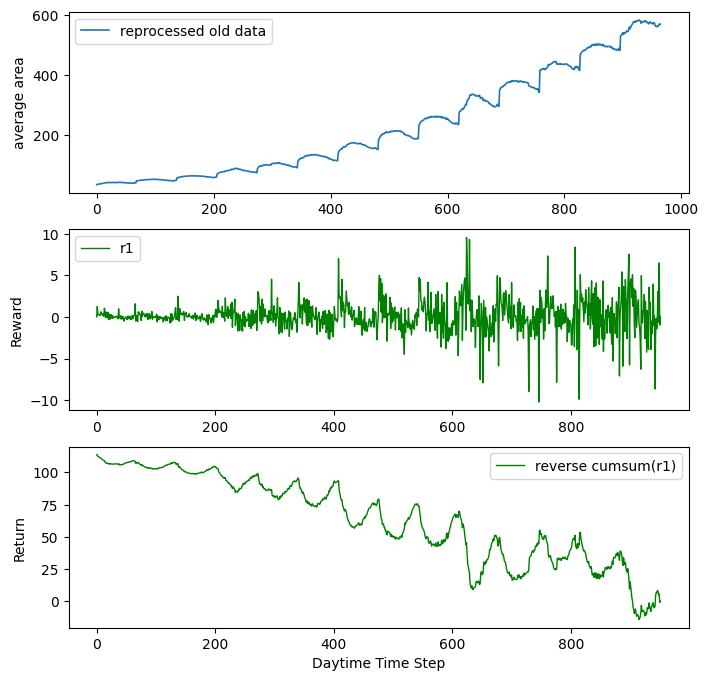

In [9]:
fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(area[1:], linewidth=1.2, label='reprocessed old data')
ax[0].legend()
ax[0].set_ylabel('average area')
ax[1].plot(r1p, 'g', linewidth=1, alpha=1, label='r1')
#ax[1].plot(r2, 'r', linewidth=1,alpha=0.7, label='r2')
ax[1].legend()
ax[1].set_ylabel('Reward')
#ax[1].set_ylim(-20,20)
ax[2].plot(R(r1p), 'g', linewidth=1, alpha=1,label='reverse cumsum(r1)')
#ax[2].plot(R(r2), 'r', linewidth=1, alpha=0.7,label='reverse cumsum(r2)')
ax[2].legend()
ax[2].set_ylabel('Return')
ax[2].set_xlabel('Daytime Time Step')

In [10]:
int_actions = []
for i in range(len(actions)): 
    a = actions[i]
    if len(a) > 1:   # if a has 6 components
        if a[-1] < 0.25: 
            int_actions.append(0)
        elif a[-1] < 0.5:
            int_actions.append(1)
        elif a[-1] < 0.75:
            int_actions.append(2)
        else: 
            int_actions.append(3)
    else: 
        int_actions.append(a[0])
print(int_actions)

NameError: name 'actions' is not defined

In [ ]:
m = 8
len_init = 3
pattern_01 = np.concatenate([np.zeros(len_init), np.full(m, 1)])
pattern_02 = np.concatenate([np.zeros(len_init), np.full(m, 2)])
pattern_03 = np.concatenate([np.zeros(len_init), np.full(m, 3)])
pattern_12 = np.concatenate([np.full(len_init, 1), np.full(m, 2)])
pattern_13 = np.concatenate([np.full(len_init, 1), np.full(m, 3)])
pattern_23 = np.concatenate([np.full(len_init, 2), np.full(m, 3)])

pattern_10 = np.concatenate([np.full(len_init, 1), np.full(m, 0)])
pattern_20 = np.concatenate([np.full(len_init, 2), np.full(m, 0)])
pattern_30 = np.concatenate([np.full(len_init, 3), np.full(m, 0)])
pattern_21 = np.concatenate([np.full(len_init, 2), np.full(m, 1)])
pattern_31 = np.concatenate([np.full(len_init, 3), np.full(m, 1)])
pattern_32 = np.concatenate([np.full(len_init, 3), np.full(m, 2)])

pattern_101 = np.concatenate([np.full(len_init, 1), np.full(m, 0), np.full(len_init, 1)])
pattern_202 = np.concatenate([np.full(len_init, 2), np.full(m, 0), np.full(len_init, 2)])

this_pattern = pattern_10

windows = np.lib.stride_tricks.sliding_window_view(int_actions, len(this_pattern))
matches = np.all(windows == this_pattern, axis=1)
match_indices = np.where(matches)[0]
print(match_indices)

[400 501 530]


(-0.1, 0.1)

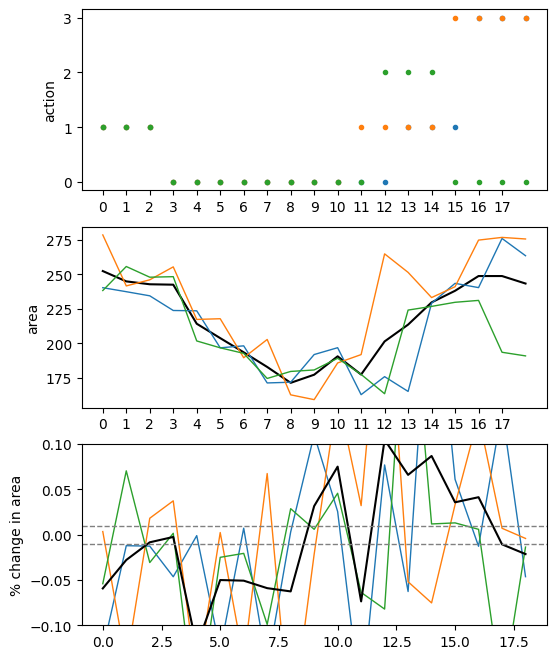

In [ ]:
n = 19
responses = []
area_responses = []
A = []
fig, ax = plt.subplots(3,1, figsize=[6,8])
for id in match_indices: 
    responses.append(2*(areas[id:id+n] - areas[id-1:id+n-1]) / (areas[id:id+n] + areas[id-1:id+n-1]))
    area_responses.append(areas[id:id+n])
    A.append(int_actions[id:id+n])
ax[0].plot(np.array(A).T, '.')
ax[0].set_ylabel('action')
ax[0].set_xticks(np.arange(0,18))
mean_area_response = np.mean(np.array(area_responses), axis=0)
ax[1].plot(mean_area_response, 'k');
ax[1].plot(np.array(area_responses).T, linewidth=1)
ax[1].set_ylabel('area')
ax[1].set_xticks(np.arange(0,18))
ax[2].plot(np.array(responses).T, linewidth=1)
mean_response = np.mean(np.array(responses), axis=0)
ax[2].plot(mean_response, 'k');
ax[2].axhline(y=0.01, color='gray', linestyle='--', linewidth=1)
ax[2].axhline(y=-0.01, color='gray', linestyle='--', linewidth=1)
ax[2].set_ylabel('% change in area')
ax[2].set_ylim(-0.1,0.1)

